In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join, unique

### Get Gaia counterparts for every candidate Kepler host star:

In [3]:
kepler_hosts = Table(np.genfromtxt('../cumulative_2019.04.17_13.39.33.csv', 
                                   delimiter=',', skip_header=150, names=True,
                                   dtype=None, encoding=None))

In [4]:
gaia_4arcsec = Table.read('/Users/mbedell/Documents/Web Design/gaia-kepler.fun/scripts/kepler_dr2_4arcsec.fits')

In [42]:
gaia_4arcsec[gaia_4arcsec['kepid'] == 3353454]['kepmag','phot_g_mean_mag','kepler_gaia_ang_dist','pmra','pmdec','bp_rp']

kepmag,phot_g_mean_mag,kepler_gaia_ang_dist,pmra,pmdec,bp_rp
,mag,arcsec,0.001 arcsec / yr,0.001 arcsec / yr,mag
float64,float32,float64,float64,float64,float32
12.95,16.93917,1.5870637628680702,-2.0365601048702042,-3.4435372282895855,1.1349487
12.95,14.568381,3.131764431911723,-1.527063575496584,-0.5539174419623825,0.9088812
12.95,18.48162,3.274348038114866,-0.04946556087521525,-10.05732543245339,nan
12.95,17.932257,3.73841124901272,-2.332807337653089,-8.800923734813194,0.97015953


In [6]:
hosts = join(kepler_hosts, gaia_4arcsec, keys='kepid')

#### Cut matches that probably aren't the correct star:

In [7]:
good = np.abs(hosts['phot_g_mean_mag'] - hosts['kepmag']) <= 1.5
hosts = hosts[good]

/Users/mbedell/miniconda3/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


In [8]:
#hosts = unique(hosts, keys='kepid', keep='first') # cut duplicate matches, keeping closest star

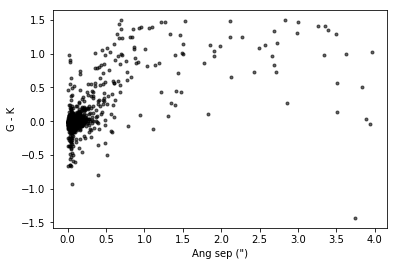

In [9]:
plt.plot(hosts['kepler_gaia_ang_dist'], hosts['phot_g_mean_mag'] - hosts['kepmag'], 'k.', alpha=0.6)
#plt.ylim([-0.5,1.0])
plt.xlabel('Ang sep (")')
plt.ylabel('G - K');

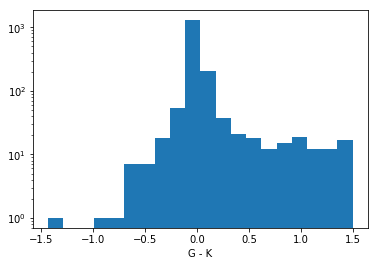

In [10]:
plt.hist((hosts['phot_g_mean_mag'] - hosts['kepmag'])[np.isfinite(hosts['phot_g_mean_mag'])], bins=20)
plt.yscale('log')
plt.xlabel('G - K');

In [11]:
good = (np.abs(hosts['phot_g_mean_mag'] - hosts['kepmag']) <= 1.5) & \
       (hosts['kepler_gaia_ang_dist'] <= 2.)

In [12]:
hosts = hosts[good]

#### Check on some statistics for how many stars have believable matches:

In [13]:
print("Number of candidate host stars:", len(kepler_hosts['kepid']))

Number of candidate host stars: 1699


In [14]:
no_match_kics = kepler_hosts[np.isin(kepler_hosts['kepid'], hosts['kepid'], invert=True)]['kepid']
match_kics, counts = np.unique(hosts['kepid'], return_counts=True)
multi_match_kics = match_kics[counts > 1]
single_match_kics = match_kics[counts == 1]

In [15]:
print("Number of candidate host stars without Gaia counterparts:", len(no_match_kics))
print("Number of candidate host stars with more than one close Gaia match:", len(multi_match_kics))

Number of candidate host stars without Gaia counterparts: 23
Number of candidate host stars with more than one close Gaia match: 44


#### Check on stars where we found more than one good match:

In [16]:
t = hosts[np.isin(hosts['kepid'], multi_match_kics)]['kepid', 'kepmag', 
                                                     'phot_g_mean_mag', 'kepler_gaia_ang_dist', 'bp_rp']

In [17]:
t

kepid,kepmag,phot_g_mean_mag,kepler_gaia_ang_dist,bp_rp
,,mag,arcsec,mag
int64,float64,float32,float64,float32
2437452,16.981,17.208113,0.2740950634926204,1.0967178
2437452,16.981,17.847225,1.7730378067971926,0.9843044
3127817,12.155,12.462681,0.4637561147880646,0.7984276
3127817,12.155,12.762624,0.7714504810069563,nan
3327992,15.582,17.050085,1.2618282090594952,nan
3327992,15.582,15.910303,0.18299279671369922,1.8951912
3458919,13.815,13.699158,1.1111097521912292,1.046216
3458919,13.815,13.910889,0.942287379813649,1.1077003


In [18]:
#t.show_in_browser(jsviewer=True)  

In general these seem to be unresolved binaries in Kepler that have been resolved by Gaia. We can therefore keep either star to adopt as the "true match." The cross-match table is already sorted by angular distance between the Kepler coordinates and the Gaia match, so let's adopt that as the deciding factor.

In [19]:
hosts = unique(hosts, keys='kepid', keep='first')

#### Check on stars without Gaia counterparts:

In [20]:
t2 = kepler_hosts[np.isin(kepler_hosts['kepid'], no_match_kics)]['kepid', 'kepler_name', 'koi_kepmag', 
                                                                 'koi_gmag', 'ra', 'dec',
                                                                 'koi_period', 'koi_prad', 'koi_disposition']

In [21]:
t2

kepid,kepler_name,koi_kepmag,koi_gmag,ra,dec,koi_period,koi_prad,koi_disposition
int64,str13,float64,float64,float64,float64,float64,float64,str14
3952651,,13.96,14.709,291.04391,39.023685,32.9045733,28.34,FALSE POSITIVE
9025922,,13.29,nan,293.26605,45.350697,11.32029599,8.02,FALSE POSITIVE
5389540,,13.259,13.846,298.46799,40.516678,10.26231992,1.98,FALSE POSITIVE
9851126,,13.183,14.341,298.79532,46.670448,8.480303653,22.25,FALSE POSITIVE
10264660,Kepler-14 b,12.128,12.363,287.70883,47.33305,6.790120801,9.86,CONFIRMED
3742855,,13.133,13.14,290.26614,38.837917,6.397185875,15.02,FALSE POSITIVE
8766222,,13.85,nan,296.39639,44.963036,5.2972293,47.7,FALSE POSITIVE
10287248,,13.987,14.839,296.69562,47.327309,4.722254104,14.45,FALSE POSITIVE
6752502,,13.826,14.69,282.15491,42.234547,4.305219002,10.34,FALSE POSITIVE


In [31]:
t2.show_in_browser(jsviewer=True)  

In [23]:
t2.write('unmatched_kics.csv', overwrite=True)

#### Of the stars with decent matches, keep only the ones with well-measured parallax & PM:

In [24]:
has_plx = np.isfinite(hosts['parallax'])
hosts = hosts[has_plx] # cut stars without 5-param DR2 solutions
print("{0} sources cut for not having a 5-parameter solution.".format(np.sum(~has_plx)))

28 sources cut for not having a 5-parameter solution.


In [25]:
bab_cuts =  (hosts['visibility_periods_used'] > 8) & \
            (hosts['astrometric_chi2_al']/(hosts['astrometric_n_good_obs_al'] - 5) < 
             1.44*np.nanmax(np.vstack([np.ones_like(hosts['phot_g_mean_mag']), 
                    np.exp(-0.4*(hosts['phot_g_mean_mag']-19.5))]), axis=0))
hosts = hosts[bab_cuts] # cut stars without much data or with poor astrometric fits
print("{0} sources cut following Babusiaux recommended solution quality cuts.".format(np.sum(~bab_cuts)))

109 sources cut following Babusiaux recommended solution quality cuts.


In [26]:
high_snr = hosts['parallax_over_error'] > 5.
hosts = hosts[high_snr] # cut stars with poorly measured parallax
print("{0} sources cut for low SNR.".format(np.sum(~high_snr)))

68 sources cut for low SNR.


In [27]:
# Cut these?
nonzero_pm = (np.sqrt(hosts['pmra']**2 + 
                      hosts['pmdec']**2)/np.sqrt(hosts['pmra_error']**2 + 
                      hosts['pmdec_error']**2) > 5.) 
#hosts = hosts[nonzero_pm]
#print("{0} sources cut for zero proper motion.".format(np.sum(~nonzero_pm)))
hosts[~nonzero_pm]

kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_time0,koi_time0_err1,koi_time0_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_tce_delivname,koi_quarters,koi_bin_oedp_sig,koi_trans_mod,koi_model_dof,koi_model_chisq,koi_datalink_dvr,koi_datalink_dvs,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,koi_srad_err1,koi_srad_err2,koi_smass,koi_smass_err1,koi_smass_err2,koi_sage,koi_sage_err1,koi_sage_err2,koi_sparprov,ra_1,dec_1,koi_kepmag,koi_gmag,koi_rmag,koi_imag,koi_zmag,koi_jmag,koi_hmag,koi_kmag,koi_fwm_stat_sig,koi_fwm_sra,koi_fwm_sra_err,koi_fwm_sdec,koi_fwm_sdec_err,koi_fwm_srao,koi_fwm_srao_err,koi_fwm_sdeco,koi_fwm_sdeco_err,koi_fwm_prao,koi_fwm_prao_err,koi_fwm_pdeco,koi_fwm_pdeco_err,koi_dicco_mra,koi_dicco_mra_err,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,solution_id,designation,source_id,random_index,gaia_ref_epoch,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,ra_kic,dec_kic,r_est,r_lo,r_hi,r_length_prior,r_result_flag,r_modality_flag,tm_designation,kepmag,teff,teff_err1,teff_err2,teff_prov,logg,logg_err1,logg_err2,logg_prov,feh,feh_err1,feh_err2,feh_prov,radius,radius_err1,radius_err2,mass,mass_err1,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [28]:
print("In total, {0} of {1} Kepler host star candidates have good Gaia DR2 counterparts.".format(len(hosts),
                                                                                                len(kepler_hosts)))

In total, 1471 of 1699 Kepler host star candidates have good Gaia DR2 counterparts.


In [29]:
hosts.write('kepler_host_matches.fits', overwrite=True)